# TimeQuant Quickstart

Demo of a streaming **Gaussian-Quantile tokenizer** for continuous time series.
- Univariate online tokenization with running mean/variance (Welford).
- Simple multivariate extension (per-dimension binning + k-means codebook).

> This notebook is standalone and dependency-light (NumPy & Matplotlib).

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt


# Utility: numerically stable running stats (Welford)
class RunningStats:
    def __init__(self, dim=None, eps=1e-8):
        self.n = 0
        self.mean = None if dim is None else np.zeros(dim, dtype=float)
        self.M2 = None if dim is None else np.zeros(dim, dtype=float)
        self.eps = eps

    def update(self, x):
        x = np.asarray(x)
        if self.mean is None:
            self.mean = np.zeros_like(x, dtype=float)
            self.M2 = np.zeros_like(x, dtype=float)
        self.n += 1
        delta = x - self.mean
        self.mean += delta / self.n
        delta2 = x - self.mean
        self.M2 += delta * delta2

    @property
    def var(self):
        if self.n < 2:
            return np.zeros_like(self.mean)
        return self.M2 / (self.n - 1)

    @property
    def std(self):
        return np.sqrt(self.var + self.eps)


# Fast approximation to the inverse CDF (PPF) of N(0,1) using Acklam's method
# Source: https://web.archive.org/web/20151030230722/http://home.online.no/~pjacklam/notes/invnorm/
def norm_ppf(p):
    if p <= 0.0 or p >= 1.0:
        if p == 0.0:
            return -np.inf
        if p == 1.0:
            return np.inf
        raise ValueError("p must be in (0,1)")
    # Coefficients in rational approximations
    a = [
        -3.969683028665376e01,
        2.209460984245205e02,
        -2.759285104469687e02,
        1.383577518672690e02,
        -3.066479806614716e01,
        2.506628277459239e00,
    ]
    b = [
        -5.447609879822406e01,
        1.615858368580409e02,
        -1.556989798598866e02,
        6.680131188771972e01,
        -1.328068155288572e01,
    ]
    c = [
        -7.784894002430293e-03,
        -3.223964580411365e-01,
        -2.400758277161838e00,
        -2.549732539343734e00,
        4.374664141464968e00,
        2.938163982698783e00,
    ]
    d = [
        7.784695709041462e-03,
        3.224671290700398e-01,
        2.445134137142996e00,
        3.754408661907416e00,
    ]
    # Define break-points
    plow = 0.02425
    phigh = 1 - plow
    if p < plow:
        q = math.sqrt(-2 * math.log(p))
        return (((((c[0] * q + c[1]) * q + c[2]) * q + c[3]) * q + c[4]) * q + c[5]) / (
            (((d[0] * q + d[1]) * q + d[2]) * q + d[3]) * q + 1
        )
    if phigh < p:
        q = math.sqrt(-2 * math.log(1 - p))
        return -(
            ((((c[0] * q + c[1]) * q + c[2]) * q + c[3]) * q + c[4]) * q + c[5]
        ) / ((((d[0] * q + d[1]) * q + d[2]) * q + d[3]) * q + 1)
    q = p - 0.5
    r = q * q
    return (
        (((((a[0] * r + a[1]) * r + a[2]) * r + a[3]) * r + a[4]) * r + a[5])
        * q
        / (((((b[0] * r + b[1]) * r + b[2]) * r + b[3]) * r + b[4]) * r + 1)
    )


class QuantileBinner:
    def __init__(self, V):
        self.V = int(V)
        qs = np.linspace(0, 1, self.V + 1)[1:-1]
        self.boundaries = np.array([norm_ppf(float(q)) for q in qs], dtype=float)

    def encode_scalar(self, z):
        # (-inf, b0], (b0, b1], ..., (b_{V-2}, inf)
        # use binary search via numpy
        return int(np.searchsorted(self.boundaries, z, side="right"))

    def decode_scalar(self, tok):
        if tok == 0:
            lo, hi = -np.inf, self.boundaries[0]
        elif tok == self.V - 1:
            lo, hi = self.boundaries[-1], np.inf
        else:
            lo, hi = self.boundaries[tok - 1], self.boundaries[tok]

        # midpoint via CDF mid-quantile
        def norm_cdf(x):  # numerical stable erf-based CDF
            return 0.5 * (1 + math.erf(x / math.sqrt(2)))

        q_lo = 0.0 if math.isinf(lo) and lo < 0 else norm_cdf(lo)
        q_hi = 1.0 if math.isinf(hi) and hi > 0 else norm_cdf(hi)
        q_mid = 0.5 * (q_lo + q_hi)
        return norm_ppf(q_mid)


class GQTokenizer:
    def __init__(self, V, eps=1e-8):
        """
        Gaussian-Quantile Tokenizer for univariate time series.

        Args:
            V: Vocabulary size
            eps: Numerical stability parameter
        """
        self.V = V
        self.eps = eps
        self.stats = RunningStats()
        self.binner = QuantileBinner(V)

    def update(self, x):
        """Update the tokenizer with new data point."""
        self.stats.update(x)

    def encode(self, x):
        """Encode data point to token."""
        z = (x - self.stats.mean) / self.stats.std
        return self.binner.encode_scalar(float(z))

    def decode(self, tok):
        """Decode token back to data point."""
        z = self.binner.decode_scalar(tok)
        return float(self.stats.mean + z * self.stats.std)

## 1) Univariate streaming demo

First 20 tokens: [ 8 12 13 14 14 12 13 13 12 13 12 14 14 14 14 14 15 14 14 13]


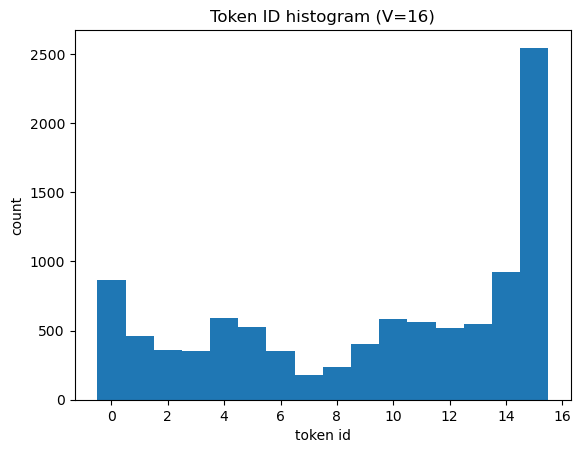

In [2]:
np.random.seed(0)
T = 10_000
# generate a nonstationary series: random walk + drift + noise
x = (
    np.cumsum(np.random.randn(T) * 0.5)
    + 0.01 * np.arange(T)
    + 0.5 * np.sin(np.arange(T) / 50)
)

tok = GQTokenizer(V=16)
tokens = np.empty(T, dtype=int)
for t in range(T):
    tok.update(x[t])
    tokens[t] = tok.encode(x[t])

print("First 20 tokens:", tokens[:20])
# Plot token histogram
plt.figure()
bins = np.arange(17) - 0.5
plt.hist(tokens, bins=bins)
plt.title("Token ID histogram (V=16)")
plt.xlabel("token id")
plt.ylabel("count")
plt.show()

## 2) Multivariate per-dimension binning + simple k-means codebook

Unique tokens used: 16/16; perplexity≈12.88


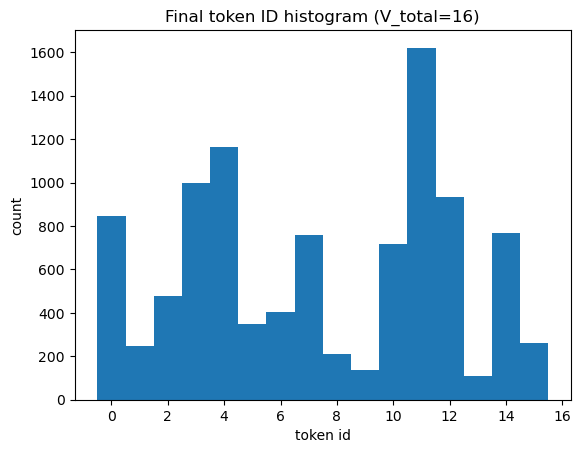

In [3]:
def kmeans_numpy(X, k, iters=50, seed=0):
    rng = np.random.default_rng(seed)
    idx = rng.choice(len(X), size=k, replace=False)
    C = X[idx].astype(float).copy()
    for _ in range(iters):
        # assign
        d2 = ((X[:, None, :] - C[None, :, :]) ** 2).sum(-1)
        y = d2.argmin(axis=1)
        # update
        for j in range(k):
            mask = y == j
            if mask.any():
                C[j] = X[mask].mean(axis=0)
    return C


D = 4
V_dim = 8  # 3-bit per dim
V_total = 16  # final vocab via codebook

# make a 4D series with correlations
cov = np.array(
    [
        [1.0, 0.6, 0.0, 0.1],
        [0.6, 1.0, 0.2, 0.0],
        [0.0, 0.2, 1.0, 0.4],
        [0.1, 0.0, 0.4, 1.0],
    ]
)
L = np.linalg.cholesky(cov)
z = np.random.randn(T, D) @ L.T
X = (np.cumsum(z, axis=0) * 0.1) + 0.1 * np.sin(np.arange(T)[:, None] / 30)

# per-dim tokenizers
toks = [GQTokenizer(V=V_dim) for _ in range(D)]
codes = np.empty((T, D), dtype=int)
for t in range(T):
    for d in range(D):
        toks[d].update(X[t, d])
        codes[t, d] = toks[d].encode(X[t, d])

# fit a tiny codebook on a subset (streaming-friendly would use minibatches)
subset = codes#[1000:6000]
centroids = kmeans_numpy(subset.astype(float), k=V_total, iters=40, seed=0)

# map each code to nearest centroid => final token id
d2 = ((codes[:, None, :] - centroids[None, :, :]) ** 2).sum(-1)
final_tokens = d2.argmin(axis=1)

# utilization & perplexity
vals, counts = np.unique(final_tokens, return_counts=True)
p = counts / counts.sum()
H = -(p * np.log(p + 1e-12)).sum()
perplexity = float(np.exp(H))
print(f"Unique tokens used: {len(vals)}/{V_total}; perplexity≈{perplexity:.2f}")

plt.figure()
bins = np.arange(V_total + 1) - 0.5
plt.hist(final_tokens, bins=bins)
plt.title("Final token ID histogram (V_total=%d)" % V_total)
plt.xlabel("token id")
plt.ylabel("count")
plt.show()

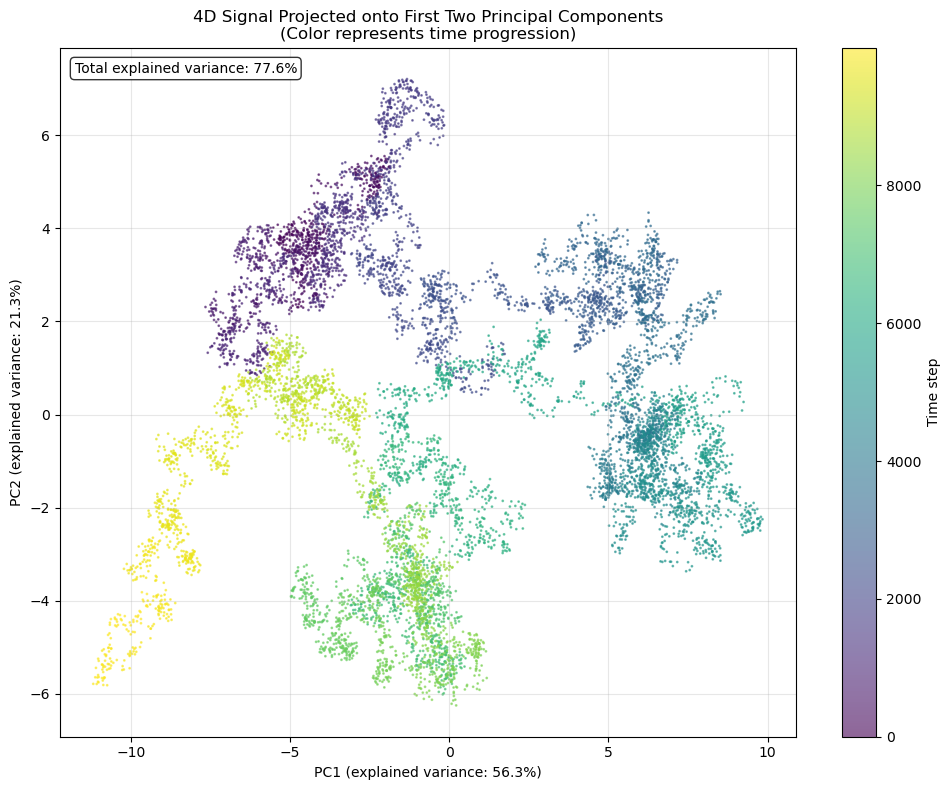

PCA explained variance ratios: [0.56311099 0.21333942]
Total explained variance by first 2 PCs: 77.6%


In [4]:
# Visualize 4D signal via PCA projection with time-based coloring
from sklearn.decomposition import PCA

# Compute PCA on the 4D signal
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Create the visualization
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    X_pca[:, 0], X_pca[:, 1], c=np.arange(T), cmap="viridis", alpha=0.6, s=1
)

plt.colorbar(scatter, label="Time step")
plt.xlabel(f"PC1 (explained variance: {pca.explained_variance_ratio_[0]:.1%})")
plt.ylabel(f"PC2 (explained variance: {pca.explained_variance_ratio_[1]:.1%})")
plt.title(
    "4D Signal Projected onto First Two Principal Components\n(Color represents time progression)"
)
plt.grid(True, alpha=0.3)

# Add some statistics
total_var = pca.explained_variance_ratio_.sum()
plt.text(
    0.02,
    0.98,
    f"Total explained variance: {total_var:.1%}",
    transform=plt.gca().transAxes,
    verticalalignment="top",
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.8),
)

plt.tight_layout()
plt.show()

print(f"PCA explained variance ratios: {pca.explained_variance_ratio_}")
print(f"Total explained variance by first 2 PCs: {total_var:.1%}")

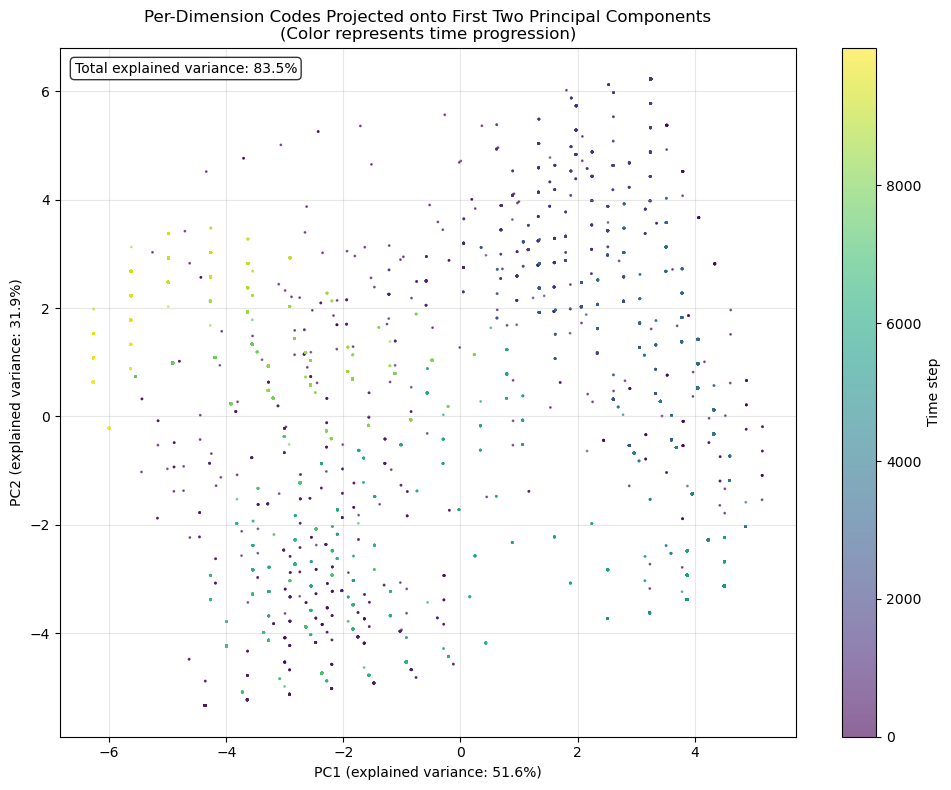

Codes PCA explained variance ratios: [0.51578678 0.31883952]
Total explained variance by first 2 PCs: 83.5%

Comparison:
Original signal - Total explained variance: 77.6%
Codes matrix - Total explained variance: 83.5%
Difference: 5.8%


In [5]:
# Visualize the per-dimension codes via PCA projection with time-based coloring
# This shows how the tokenized representation looks in 2D space

# Compute PCA on the codes matrix (T x D) - codes was already computed in the previous cell
from sklearn.decomposition import PCA

pca_codes = PCA(n_components=2)
codes_pca = pca_codes.fit_transform(codes.astype(float))

# Create the visualization
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    codes_pca[:, 0], codes_pca[:, 1], c=np.arange(T), cmap="viridis", alpha=0.6, s=1
)

plt.colorbar(scatter, label="Time step")
plt.xlabel(f"PC1 (explained variance: {pca_codes.explained_variance_ratio_[0]:.1%})")
plt.ylabel(f"PC2 (explained variance: {pca_codes.explained_variance_ratio_[1]:.1%})")
plt.title(
    "Per-Dimension Codes Projected onto First Two Principal Components\n(Color represents time progression)"
)
plt.grid(True, alpha=0.3)

# Add some statistics
total_var_codes = pca_codes.explained_variance_ratio_.sum()
plt.text(
    0.02,
    0.98,
    f"Total explained variance: {total_var_codes:.1%}",
    transform=plt.gca().transAxes,
    verticalalignment="top",
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.8),
)

plt.tight_layout()
plt.show()

print(f"Codes PCA explained variance ratios: {pca_codes.explained_variance_ratio_}")
print(f"Total explained variance by first 2 PCs: {total_var_codes:.1%}")

# Compare with original signal (need to compute PCA on original signal first)
pca_original = PCA(n_components=2)
X_pca = pca_original.fit_transform(X)
total_var_original = pca_original.explained_variance_ratio_.sum()

print(f"\nComparison:")
print(f"Original signal - Total explained variance: {total_var_original:.1%}")
print(f"Codes matrix - Total explained variance: {total_var_codes:.1%}")
print(f"Difference: {abs(total_var_original - total_var_codes):.1%}")

In [ ]:
# Visualize the centroids via PCA projection with time-based coloring
# This shows how the decoded representation looks in 2D space

# Compute PCA on the codes matrix (T x D) - codes was already computed in the previous cell
from sklearn.decomposition import PCA

pca_codes = PCA(n_components=2)
codes_pca = pca_codes.fit_transform(codes.astype(float))

# Create the visualization
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    codes_pca[:, 0], codes_pca[:, 1], c=np.arange(T), cmap="viridis", alpha=0.6, s=1
)

plt.colorbar(scatter, label="Time step")
plt.xlabel(f"PC1 (explained variance: {pca_codes.explained_variance_ratio_[0]:.1%})")
plt.ylabel(f"PC2 (explained variance: {pca_codes.explained_variance_ratio_[1]:.1%})")
plt.title(
    "Per-Dimension Codes Projected onto First Two Principal Components\n(Color represents time progression)"
)
plt.grid(True, alpha=0.3)

# Add some statistics
total_var_codes = pca_codes.explained_variance_ratio_.sum()
plt.text(
    0.02,
    0.98,
    f"Total explained variance: {total_var_codes:.1%}",
    transform=plt.gca().transAxes,
    verticalalignment="top",
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.8),
)

plt.tight_layout()
plt.show()

print(f"Codes PCA explained variance ratios: {pca_codes.explained_variance_ratio_}")
print(f"Total explained variance by first 2 PCs: {total_var_codes:.1%}")

# Compare with original signal (need to compute PCA on original signal first)
pca_original = PCA(n_components=2)
X_pca = pca_original.fit_transform(X)
total_var_original = pca_original.explained_variance_ratio_.sum()

print(f"\nComparison:")
print(f"Original signal - Total explained variance: {total_var_original:.1%}")
print(f"Codes matrix - Total explained variance: {total_var_codes:.1%}")
print(f"Difference: {abs(total_var_original - total_var_codes):.1%}")

In [6]:
# np.unique(codes, axis=0), len(np.unique(codes, axis=0)) # V_dim^D - 1

# np.unique(codes_pca, axis=0).shape # V_dim^D - 1

# centroids # V_total (final vocab size)

# plt.plot(final_tokens)